In [1]:
import boto3
from botocore.exceptions import ClientError
import json

def get_secret(secret_name):
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    secret = get_secret_value_response['SecretString']
    
    return json.loads(secret)

In [7]:
import psycopg2

conn = psycopg2.connect(host=get_secret('postgresql')['host'],
                      user=get_secret('postgresql')['username'],
                      password = get_secret('postgresql')['password'],
                      dbname=get_secret('postgresql')['engine'])

cur = conn.cursor()

In [19]:
 """
WITH PreviousYearPopulation AS (
    SELECT
        year,
        pop AS population,
        LAG(pop, 1) OVER (ORDER BY year) AS previous_year_population
    FROM
        population
    WHERE
        fips = '44' -- FIPS for Rhode Island
)
SELECT
    year,
    growth_rate_percentage
FROM (
    SELECT
        year,
        CASE
            WHEN previous_year_population IS NOT NULL AND previous_year_population > 0
            THEN ((population - previous_year_population)::numeric / previous_year_population) * 100
            ELSE NULL
        END AS growth_rate_percentage
    FROM
        PreviousYearPopulation
) AS growth_data
ORDER BY
    year;
"""

"\nWITH PreviousYearPopulation AS (\n   SELECT\n       year,\n       pop AS population,\n       LAG(pop, 1) OVER (ORDER BY year) AS previous_year_population\n   FROM\n       population\n   WHERE\n       fips = '44' -- FIPS for Rhode Island\n)\nSELECT\n   year,\n   growth_rate_percentage\nFROM (\n   SELECT\n       year,\n       CASE\n           WHEN previous_year_population IS NOT NULL AND previous_year_population > 0\n           THEN ((population - previous_year_population)::numeric / previous_year_population) * 100\n           ELSE NULL\n       END AS growth_rate_percentage\n   FROM\n       PreviousYearPopulation\n) AS growth_data\nORDER BY\n   year;\n"

/tmp/ipykernel_9088/4020918933.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  population_df = pd.read_sql_query(sql_query, conn)


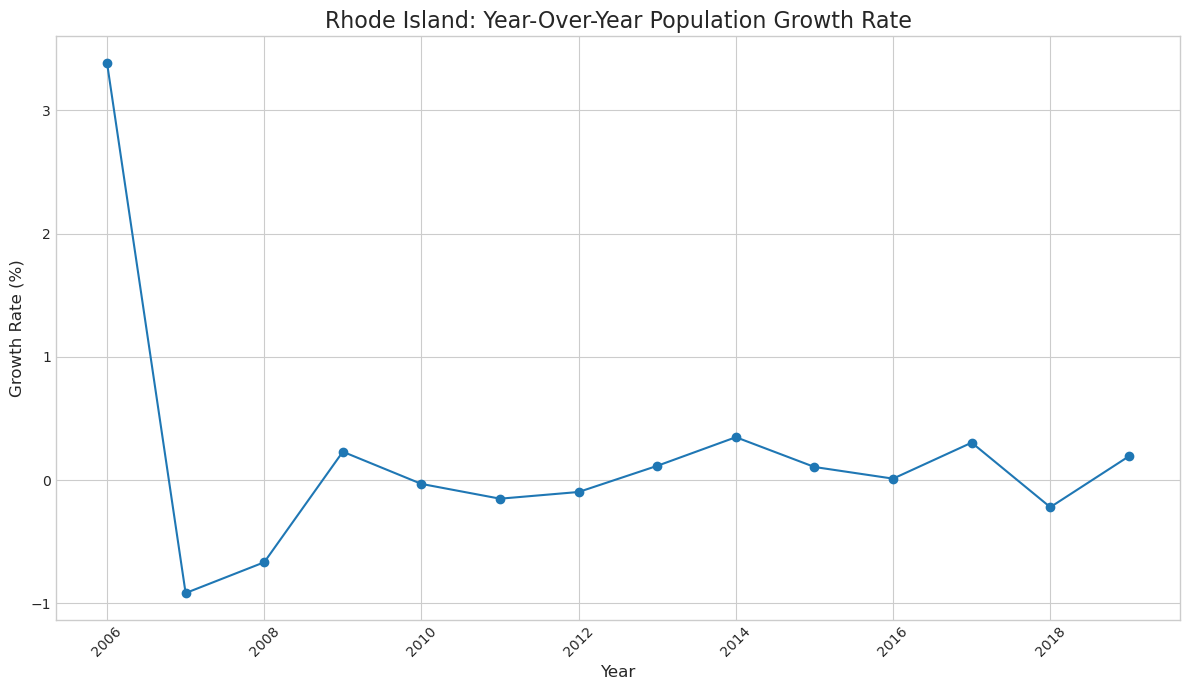

In [21]:
try:
    db_credentials = get_secret('postgresql')
    
    with psycopg2.connect(
        host=db_credentials['host'],
        user=db_credentials['username'],
        password=db_credentials['password'],
        dbname=db_credentials.get('dbname', db_credentials.get('engine'))
    ) as conn:
        population_df = pd.read_sql_query(sql_query, conn)

    # Prepare data for plotting
    plot_df = population_df.dropna(subset=['growth_rate_percentage']).copy()
    plot_df['year'] = plot_df['year'].astype(int)

    # Create the line chart
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 7))
    ax.plot(plot_df['year'], plot_df['growth_rate_percentage'], marker='o', linestyle='-')
    
    # Add titles and labels
    ax.set_title('Rhode Island: Year-Over-Year Population Growth Rate', fontsize=16)
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Growth Rate (%)', fontsize=12)
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

except Exception as error:
    print(f"An error occurred: {error}")

In [ ]:
cur.close()
conn.close()